## EMMA steps 2-4: PCA, EMMA model building, EMMA model validation
-----------------------------------------------------------------------

## This notebook defines 4 functions to perform the crucial steps for EMMA:

### 1. Event-based PCA: projecting streamwater samples and potential endmembers into PCA space to select endmembers for EMMA
#### -  Tracers selected in EMMA step 1: bivariate plots to ID conservative mixing (see other notebook)
####  - MED note that my ealier python code had a mistake in that separate PCAs were performed on the streamwater and EM datasets. We want the same coordinate system to determine their relationships, so this code rectifies that issue.
#### - Event-based PCAs: take as function parameters: site, date range, list of endmembers, number of components (default is 2)
#### - I use scikit-learn's `pca.transform` to project the scaled endmember data into the vector space called by running `pca.fit_transform` on the scaled streamwater data.

### 2. Event-based EMMAs: takes as function parameters: site, date range, list of EMs.
#### - This notebook uses the SciPy packages's `constrained sequential least squares programming method for non-linear optimzation` (SLSQP, more details [here](https://docs.scipy.org/doc/scipy/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp)). This is similar to the [EMMALAB v. 1.1](https://www.hydroshare.org/resource/90ad78faec9f41c180d9057b9e815785/) use of MatLab's `fmincon` function (find minimum of constrained nonlinear multivariable function), details [here](https://www.mathworks.com/help/optim/ug/fmincon.html). I have another notebook that defines a similar function using constrained linear least squares for a linear optimization (CLLS).

### 3. Calculate EMMA-predicted tracer values for each streamwater sample.

### 4. Plot EMMA-predicted tracer values vs observed
-------------------------------------------------------------------------
## TO DO

- [x] Add R<sup>2</sup> to function to tracer obs-pred plots (Function 4)
- [x] Save figures for Function 4 to output directory
- [x] Add option for EM triangle bounding to PCA plots
        - Not here but in PCA notebook now
- [x] Add option for 1 STD error bars to PCA plots
        - Not here but in PCA notebook now
- [x] Add RMSE to model vs. pred error plots

### WADE

- [x] Event A 12/11 ROS
- [x] Event B 12/29 ROS
- [x] Event D 3/4 RoS
- [x] Event E 3/11 ROS
- [x] Event F 3/26 Freshet
      
### POTASH

- [ ] Event A 12/11 ROS
- [ ] Event B 12/29 ROS
- [ ] Event C 2/24 ROS
- [ ] Event D 3/4 RoS
- [ ] Event F 3/26 Freshet

In [57]:
#####################################
# PCA of streamwater and EMs ########
# Megan E Duffy 07/18/2025 ##########
# Part of EMMA workflow #############
# EVENT LEVEL PCA FOR EMMA ##########
#####################################

# Set working directory
import os
os.chdir("/home/millieginty/OneDrive/git-repos/EMMA/")

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize


# Define event-specfic PCA plot function

def plot_event_pca(
    data,
    site,
    start_date,
    end_date,
    endmember_ids,
    title="Event-Specific PCA"
):
    """
    Generate PCA plot for a specific storm event, following the EMMALAB workflow:
    PCA is fit ONLY on streamwater (mixture) data, then endmembers are projected
    into that PCA space.

    Parameters:
        data (DataFrame): Full dataframe containing stream and endmember samples.
        site (str): Site name ("Wade" or "Hungerford").
        start_date (str or datetime): Start of storm event (e.g., "2023-04-01").
        end_date (str or datetime): End of storm event (e.g., "2023-04-04").
        endmember_ids (list of str): List of Sample IDs to use as endmembers.
        title (str): Title for the plot.
    """

    # Site-specific tracers
    if site == "Wade":
        tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O', 'Na_mg_L']
    elif site == "Hungerford":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    else:
        raise ValueError("Site not recognized. Use 'Wade' or 'Hungerford'.")

    # Ensure datetime column is datetime type
    data['Datetime'] = (data['Date'] + ' ' + data['Time']) # Combine the strings of original inventory Date and Time cols
    data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce") 
    data = data[data['Datetime'].notna()] # NA dates (we have a couple in the RI23 dataset) not useful - prune 

    # Subset streamwater (mixture) in date range and site
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow", "Isco"])) &
        (data["Datetime"] >= pd.to_datetime(start_date)) &
        (data["Datetime"] <= pd.to_datetime(end_date))
    ].copy()

    # Subset endmembers by Sample ID
    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Drop NA for stream tracers
    subset_stream = stream[tracers].dropna().copy()
    subset_stream["Group"] = "Streamwater"
    subset_stream["Type"] = "Streamwater"
    subset_stream["Datetime"] = stream["Datetime"]

    # Fill NA for endmembers with mean (per tracer)
    subset_endmembers = endmembers[tracers].copy()
    subset_endmembers = subset_endmembers.fillna(subset_endmembers.mean())
    subset_endmembers["Group"] = "Endmember"
    subset_endmembers["Type"] = endmembers["Type"].values
    subset_endmembers["Datetime"] = endmembers["Datetime"].values

    # -----------------------
    # PCA logic 
    # -----------------------

    # 1. Fit scaler ONLY on streamwater using fit_transform
    scaler = StandardScaler()
    scaled_stream = scaler.fit_transform(subset_stream[tracers])

    # 2. PCA ONLY on scaled streamwater using pca.fit_transform
    pca = PCA(n_components=2)
    stream_pca_result = pca.fit_transform(scaled_stream)
    subset_stream["PC1"] = stream_pca_result[:, 0]
    subset_stream["PC2"] = stream_pca_result[:, 1]

    # 3. Project endmembers using same scaler & PCA using and transform and pca.transform
    scaled_endmembers = scaler.transform(subset_endmembers[tracers])
    endmember_pca_result = pca.transform(scaled_endmembers)
    subset_endmembers["PC1"] = endmember_pca_result[:, 0]
    subset_endmembers["PC2"] = endmember_pca_result[:, 1]

    # Combine for plotting
    combined = pd.concat([subset_stream, subset_endmembers], ignore_index=True)

    # -----------------------
    # Plotting
    # -----------------------
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot streamwater points
    sw = combined[combined["Group"] == "Streamwater"]
    ax.scatter(sw["PC1"], sw["PC2"], marker='+', c='blue', alpha=0.5, label='Streamwater')

    # Plot endmembers with distinct markers/colors
    endmember_markers = {
        'Rain': 'o', 'Snow': 's', 'Snowmelt lysimeter': '^', 'Precip': '*',
        'Soil water lysimeter dry': '<', 'Soil water lysimeter wet': '>',
        'Groundwater': 'D', 'Baseflow': 'P'
    }
    colors = ['#d7191c', '#fdae61', '#abdda4', '#2b83ba', '#2ca25f', '#636363', '#8856a7', '#d95f0e']
    for (etype, color) in zip(endmember_markers.keys(), colors):
        em = combined[(combined["Type"] == etype)]
        if not em.empty:
            ax.scatter(em["PC1"], em["PC2"],
                       marker=endmember_markers[etype], c=color, edgecolors='black',
                       alpha=0.8, s=100, label=etype)
            for _, row in em.iterrows():
                if pd.notnull(row["Datetime"]):
                    ax.text(row["PC1"], row["PC2"], row["Datetime"].strftime('%m/%d'),
                            fontsize=12, ha='right')

    # Variance explained for axis labels
    pc1_var = pca.explained_variance_ratio_[0] * 100
    pc2_var = pca.explained_variance_ratio_[1] * 100
    ax.set_xlabel(f"PC1 ({pc1_var:.1f}%)")
    ax.set_ylabel(f"PC2 ({pc2_var:.1f}%)")

    ax.set_title(title)
    ax.legend(bbox_to_anchor=(1.02, 1.02), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Return info
    return tracers, pca

#########################
# STEP 2: EMMA FUNCTION #
#########################

def run_emma_event(data, site, start_date, end_date, endmember_ids, n_components=2):
    """
    Perform PCA-based End-Member Mixing Analysis (EMMA) for a storm event.
    
    Parameters:
        data (DataFrame): Full dataframe with streamwater and endmember data
        site (str): Site name ("Wade" or "Hungerford")
        start_date (str): Event start date (e.g., '2023-04-01')
        end_date (str): Event end date (e.g., '2023-04-04')
        endmember_ids (list of str): List of sample IDs to use as endmembers
        n_components (int): Number of principal components (default = 2)

    Returns:
        fractions_df (DataFrame): Streamwater samples with source fractions
    """
    
    # Site-specific tracer selection
    if site == "Wade":
        tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O', 'Na_mg_L']
    elif site == "Hungerford":
        tracers = ['Ca_mg_L', 'Cl_mg_L', 'Si_mg_L', 'Na_mg_L', 'Mg_mg_L', 'dD', 'd18O']
    else:
        raise ValueError("Site not recognized. Use 'Wade' or 'Hungerford'.")

    # Ensure datetime format
    #data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y", errors="coerce") #OLD

    # Ensure datetime column is datetime type
    data['Datetime'] = (data['Date'] + ' ' + data['Time']) # Combine the strings of original inventory Date and Time cols
    data['Datetime'] = pd.to_datetime(data['Datetime'], format="%m/%d/%Y %H:%M", errors="coerce") 
    data = data[data['Datetime'].notna()] # NA dates (we have a couple in the RI23 dataset) not useful - prune 

    # --- Subset streamwater and endmembers ---
    stream = data[
        (data["Site"] == site) &
        (data["Type"].isin(["Grab", "Grab/Isco", "Baseflow", "Isco"])) &
        (data["Datetime"] >= pd.to_datetime(start_date)) &
        (data["Datetime"] <= pd.to_datetime(end_date))
    ].copy()

    endmembers = data[
        (data["Site"] == site) &
        (data["Sample ID"].isin(endmember_ids))
    ].copy()

    # Clean + prepare
    stream_clean = stream[tracers].dropna().copy()
    stream_clean["Group"] = "Streamwater"
    stream_clean["Datetime"] = stream["Datetime"]

    end_clean = endmembers[tracers].copy()
    end_clean = end_clean.fillna(end_clean.mean())
    end_clean["Group"] = "Endmember"
    end_clean["Datetime"] = endmembers["Datetime"].values
    end_clean["Type"] = endmembers["Type"].values

    combined = pd.concat([stream_clean, end_clean], ignore_index=True)

    # --- PCA on combined data ---
    scaler = StandardScaler()
    scaled = scaler.fit_transform(combined[tracers])

    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(scaled)

    combined["PC1"] = pca_result[:, 0]
    combined["PC2"] = pca_result[:, 1]

    # --- Separate stream and endmembers in PC space ---
    pc_cols = [f"PC{i+1}" for i in range(n_components)]
    stream_pcs = combined[combined["Group"] == "Streamwater"][pc_cols].values
    endmember_pcs = combined[combined["Group"] == "Endmember"][pc_cols].values
    endmember_labels = combined[combined["Group"] == "Endmember"]["Type"].values

    # --- EMMA optimization ---
    def objective(Ii, xi, B):
        xi_pred = np.dot(Ii, B)
        return np.linalg.norm(xi - xi_pred)

    constraints = (
        {'type': 'eq', 'fun': lambda Ii: np.sum(Ii) - 1},
        {'type': 'ineq', 'fun': lambda Ii: Ii},
        {'type': 'ineq', 'fun': lambda Ii: 1 - Ii},
    )

    fractions = []
    for xi in stream_pcs:
        init_guess = np.ones(endmember_pcs.shape[0]) / endmember_pcs.shape[0]
        result = minimize(objective, init_guess, args=(xi, endmember_pcs), constraints=constraints, method='SLSQP')
        fractions.append(result.x if result.success else np.nan)

    fractions = np.vstack(fractions)

    def project_simplex_nonneg(vec):
        vec = np.where(vec < 0, 0, vec)          # set negatives to zero
        s = vec.sum()
        if s == 0:
            return np.ones_like(vec) / len(vec)  # all zero? equal fractions
        return vec / s

    fractions = np.apply_along_axis(project_simplex_nonneg, 1, fractions)

    # --- Assemble output DataFrame ---
    fraction_cols = list(endmember_labels)
    stream_info = stream.reset_index(drop=True)[['Sample ID', 'Datetime', 'Site']]
    fractions_df = pd.concat([stream_info, pd.DataFrame(fractions, columns=fraction_cols)], axis=1)
    fractions_df["Sum_Fractions"] = fractions_df[fraction_cols].sum(axis=1)

    #return fractions_df, etc
    return fractions_df, scaler, pca, end_clean

##########################
# STEP 3. ERROR FUNCTION #
##########################

def predict_tracers_from_fractions(fractions_df, endmembers_df, tracer_cols):
    """
    Use EMMA fractions to predict tracer concentrations in streamwater samples.

    Parameters:
        fractions_df (DataFrame): Output from run_emma_event_fuss (includes fractions)
        endmembers_df (DataFrame): Subset of endmember data used in EMMA
        tracer_cols (list of str): List of tracer column names

    Returns:
        predicted_df (DataFrame): DataFrame with predicted tracer concentrations
    """
    # Unique endmember types used
    endmember_types = [col for col in fractions_df.columns if col in endmembers_df['Type'].unique()]

    # Get endmember mean tracer values by type
    em_means = endmembers_df.groupby("Type")[tracer_cols].mean()

    # Matrix of shape (n_endmembers, n_tracers)
    C = em_means.loc[endmember_types].values

    # Fractions matrix (n_samples, n_endmembers)
    F = fractions_df[endmember_types].values

    # Predicted concentrations (n_samples x n_tracers)
    predicted = np.dot(F, C)

    predicted_df = pd.DataFrame(predicted, columns=[f"{t}_predicted" for t in tracer_cols])
    predicted_df["Sample ID"] = fractions_df["Sample ID"]
    predicted_df["Datetime"] = fractions_df["Datetime"]

    return predicted_df

##############################################
# STEP 4. PLOT PREDICTED VS OBSERVED TRACERS #
##############################################

def plot_observed_vs_predicted(title, predicted_df, stream_df, tracer_cols):
    """
    Plot observed vs predicted tracer concentrations, with R² and RMSE annotations.

    Parameters:
        predicted_df (DataFrame): Output from predict_tracers_from_fractions
        stream_df (DataFrame): Original streamwater data
        tracer_cols (list): List of tracer names
    """
    import matplotlib.pyplot as plt

    # 🔹 Increase global font size for all plot elements
    plt.rcParams.update({"font.size": 16})  

    # Merge observed and predicted data
    merged = pd.merge(predicted_df, stream_df, on=["Sample ID", "Datetime"])

    n = len(tracer_cols)
    fig, axes = plt.subplots(1, n, figsize=(5 * n, 5))

    if n == 1:
        axes = [axes]

    for i, tracer in enumerate(tracer_cols):
        ax = axes[i]

        # Drop rows with missing values for this tracer
        tmp = merged[[tracer, f"{tracer}_predicted"]].dropna()

        # Scatter observed vs predicted
        ax.scatter(tmp[tracer], tmp[f"{tracer}_predicted"], alpha=0.7)

        # 1:1 line
        lims = [tmp.min().min(), tmp.max().max()]
        ax.plot(lims, lims, 'k--')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

        # Regression + metrics
        if len(tmp) > 1:  # need at least 2 points
            X = tmp[[tracer]].values.reshape(-1, 1)
            y = tmp[f"{tracer}_predicted"].values

            # R²
            model = LinearRegression().fit(X, y)
            r2 = model.score(X, y)

            # RMSE
            mse = mean_squared_error(tmp[tracer], tmp[f"{tracer}_predicted"])
            rmse = np.sqrt(mse)

            # Add text box with R² and RMSE
            ax.text(
                0.05, 0.95,
                f"R² = {r2:.2f}\nRMSE = {rmse:.2f}",
                transform=ax.transAxes,
                ha="left", va="top",
                fontsize=14,  # slightly larger than base
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none")
            )

        ax.set_title(tracer, fontsize=18)
        ax.set_xlabel("Observed", fontsize=16)
        ax.set_ylabel("Predicted", fontsize=16)

    plt.suptitle(title, fontsize=20, y=1.05)
    plt.tight_layout()

    # Ensure output directory exists
    os.makedirs("output/EMMA-error-plots", exist_ok=True)

    # Create safe filename from title
    safe_title = "".join(c if c.isalnum() or c in (" ", "_", "-") else "_" for c in title)
    filename = os.path.join("output/EMMA-error-plots", f"{safe_title}.png")

    # Save the figure
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ Figure saved to {filename}")

def plot_emma_fractions_with_hydrograph(
    fractions_df,
    discharge_csv,
    start_date,
    end_date,
    site,
    discharge_time_col="Timestamp (UTC-04:00)",
    discharge_value_col="Value",
    title=None
):
    """
    Plot EMMA source fractions beneath a stream hydrograph for a storm event.

    Parameters
    ----------
    fractions_df : DataFrame
        Output from run_emma_event(). Must include:
        - 'Datetime'
        - one column per endmember (fractions)
    discharge_csv : str
        Path to AQUARIUS discharge CSV file.
    start_date, end_date : str or datetime
        Storm event window.
    site : str
        Site name for plot labeling.
    discharge_time_col : str
        Local-time timestamp column in discharge CSV.
    discharge_value_col : str
        Discharge column (m3/s).
    title : str, optional
        Figure title.
    """

    # -------------------------
    # Read and prep discharge
    # -------------------------
    Q = pd.read_csv(
        discharge_csv,
        comment="#"
    )

    Q[discharge_time_col] = pd.to_datetime(Q[discharge_time_col])
    Q = Q.rename(columns={discharge_value_col: "Discharge_cms"})

    Q = Q[
        (Q[discharge_time_col] >= pd.to_datetime(start_date)) &
        (Q[discharge_time_col] <= pd.to_datetime(end_date))
    ].copy()

    # -------------------------
    # Prep fractions
    # -------------------------
    frac = fractions_df.copy()
    frac["Datetime"] = pd.to_datetime(frac["Datetime"])

    frac = frac[
        (frac["Datetime"] >= pd.to_datetime(start_date)) &
        (frac["Datetime"] <= pd.to_datetime(end_date))
    ].sort_values("Datetime")

    # Identify fraction columns automatically
    fraction_cols = [
        c for c in frac.columns
        if c not in ["Sample ID", "Datetime", "Site", "Sum_Fractions"]
    ]

    # -------------------------
    # Define EMMA stack order and colors
    # -------------------------

    # Canonical groupings (handles multiple naming conventions)
    baseflow_keys = ["Baseflow", "Groundwater"]
    soil_keys = ["Soil water lysimeter dry", "Soil water lysimeter wet", "Soil water"]
    melt_keys = ["Snowmelt lysimeter", "Meltwater", "Snowmelt", "Snow"]

    # Map fraction columns to conceptual sources
    def match_cols(keys):
        return [c for c in fraction_cols if c in keys]

    baseflow_cols = match_cols(baseflow_keys)
    soil_cols = match_cols(soil_keys)
    melt_cols = match_cols(melt_keys)

    # Final stacked order: bottom → top
    stacked_cols = baseflow_cols + soil_cols + melt_cols

    if len(stacked_cols) == 0:
        raise ValueError("No recognizable EMMA fraction columns found.")

    # Colors (matched to order)
    color_map = {}
    for c in baseflow_cols:
        color_map[c] = "steelblue"
    for c in soil_cols:
        color_map[c] = "firebrick"
    for c in melt_cols:
        color_map[c] = "gold" if c != "Snow" else "yellow"

    stack_colors = [color_map[c] for c in stacked_cols]
    
    # -------------------------
    # Plot
    # -------------------------
    fig, (ax_q, ax_f) = plt.subplots(
        2, 1,
        figsize=(12, 8),
        sharex=True,
        gridspec_kw={"height_ratios": [2, 1]}
    )

    # ---- Hydrograph ----
    ax_q.plot(
        Q[discharge_time_col],
        Q["Discharge_cms"],
        color="black",
        linewidth=2
    )

    ax_q.set_ylabel("Discharge (m³ s⁻¹)")
    ax_q.set_title(
        title if title else f"{site} storm event: discharge and EMMA fractions"
    )

    # ---- EMMA fractions (stacked) ----
    ax_f.stackplot(
        frac["Datetime"],
        [frac[c] for c in stacked_cols],
        labels=stacked_cols,
        colors=stack_colors,
        alpha=0.9
    )

    ax_f.set_ylabel("Source fraction")
    ax_f.set_ylim(0, 1)
    ax_f.legend(
        loc="upper center",
        bbox_to_anchor=(0.5, -0.85),
        ncol=3,
        frameon=False
    )

    # ---- Shared x-axis ----
    ax_f.set_xlabel("Dateime")
    ax_f.tick_params("x", rotation=45)

    # Formatting
    for ax in (ax_q, ax_f):
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

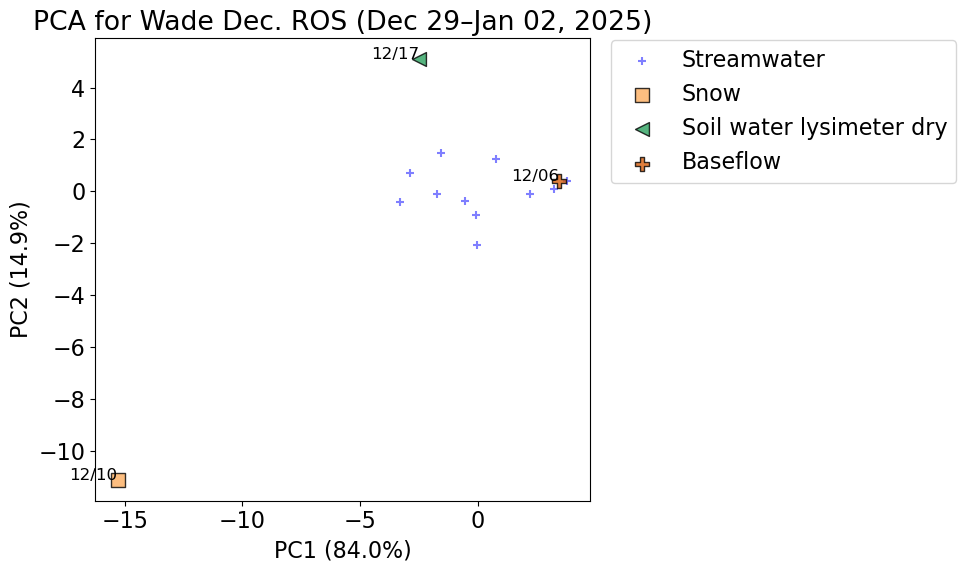

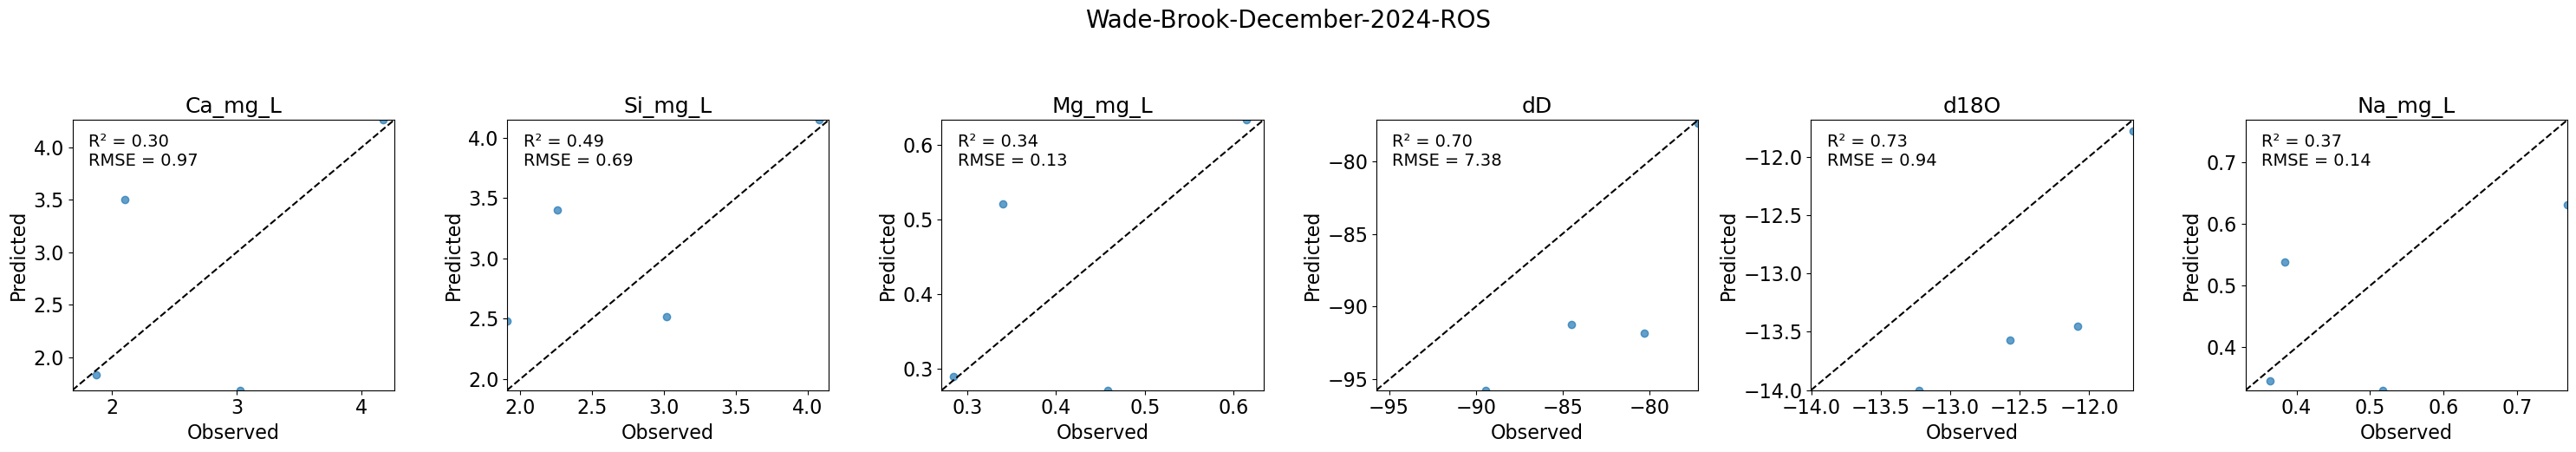

✅ Figure saved to output/EMMA-error-plots/Wade-Brook-December-2024-ROS.png


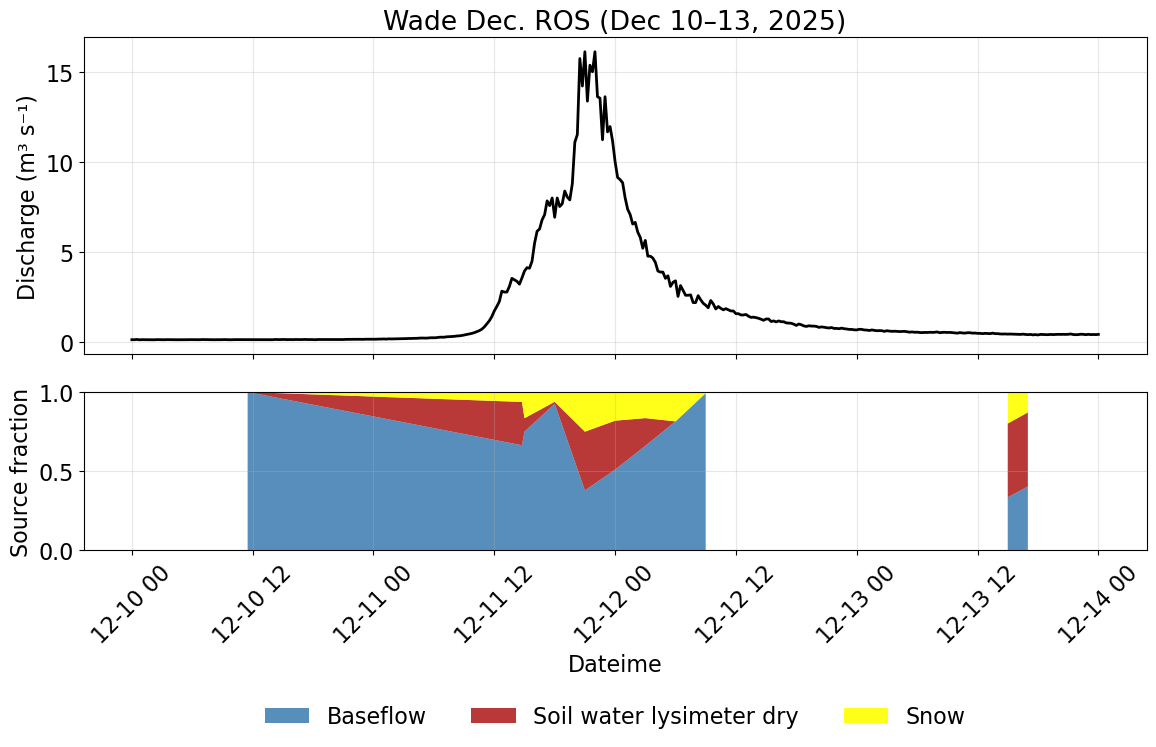

In [64]:
# Load the full RI25 dataset
df = pd.read_csv("data/newrnet-chemistry/RI25/RI25-IC-ICP-isotope-joined.csv")

####################
# Wade RI25 events #
####################

# Step 1: PCA: Wade December ROS event
# Event A
# Wade 12/29 ROS event
# Endmembers: 
            #"RI25-1128", Snow cores from Dec '24                   
            #"RI25-1123", # Soil water lysimeter dry 12/06/2024
            #"RI25-1126"]#, #Baseflow 12/06/2024

wade_decros_tracers, wade_decros_pca = plot_event_pca(
    data=df,
    site="Wade",
    start_date="2024-12-10 00:00:00",
    end_date="2025-01-04 00:00:00",
    endmember_ids=["RI25-1128", #"RI25-1130", # Snow cores from Dec '24                   
                   "RI25-1123", #"RI25-1115", #"RI25-1305", # Soil water lysimeter dry 
                   "RI25-1126"],#, "RI25-1031", "RI25-1090",],  #Baseflow
    title="PCA for Wade Dec. ROS (Dec 29–Jan 02, 2025)"
)

# Step 2: EMMA: Wade December ROS event
# Event A
# Wade 12/29 ROS event
# Endmembers: 
            #"RI25-1128", Snow cores from Dec '24                   
            #"RI25-1123", # Soil water lysimeter dry 12/06/2024
            #"RI25-1126"]#, #Baseflow 12/06/2024

wade_decros_fractions_df, wade_decros_scaler, wade_decros_pca, wade_decros_endmembers_df = run_emma_event(
    data=df,
    site="Wade",
    start_date="2024-12-10 00:00:00",
    end_date="2025-01-04 00:00:00",
    endmember_ids=["RI25-1128", #"RI25-1130", # Snow cores from Dec '24                   
                   "RI25-1123", #"RI25-1115", #"RI25-1305", # Soil water lysimeter dry 
                   "RI25-1126"]#, "RI25-1031", "RI25-1090",],  #Baseflow 
)

wade_tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O', 'Na_mg_L']

# Call the prediction function
wade_decros_predicted = predict_tracers_from_fractions(
    fractions_df=wade_decros_fractions_df,
    endmembers_df=wade_decros_endmembers_df,
    tracer_cols=wade_tracers
)

# Plot observed vs predicted tracer values
plot_observed_vs_predicted("Wade-Brook-December-2024-ROS", wade_decros_predicted, df, wade_tracers)

plot_emma_fractions_with_hydrograph(
    fractions_df= wade_decros_fractions_df,
    discharge_csv="/home/millieginty/OneDrive/git-repos/LCBP-interannual-EMMAs/Data/StreamSensor_data/Discharge.Discharge_cms@Wade_Brook.20221001.csv",
    start_date="2024-12-10 00:00:00",
    end_date="2024-12-14 00:00:00",
    site="Wade",
    title="Wade Dec. ROS (Dec 10–13, 2025)"
)

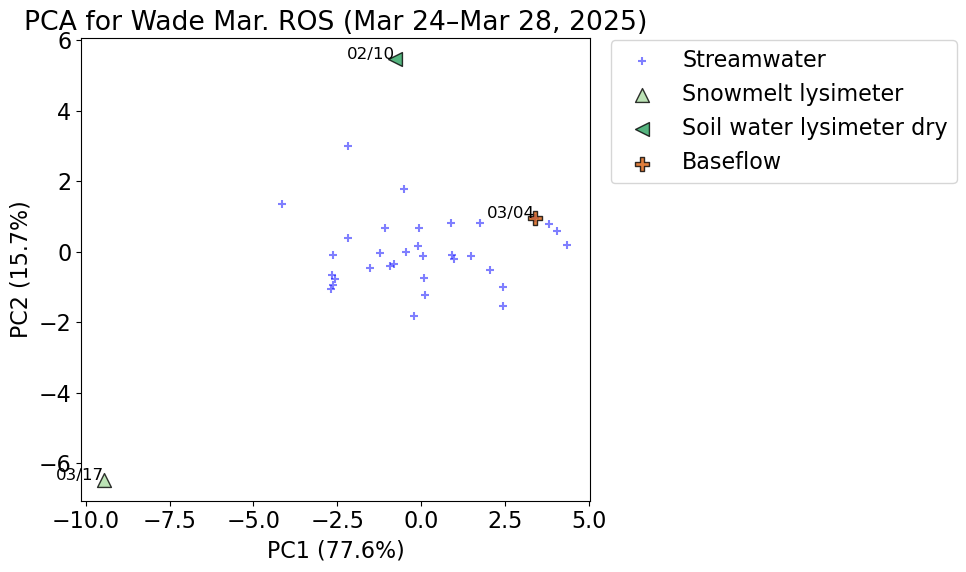

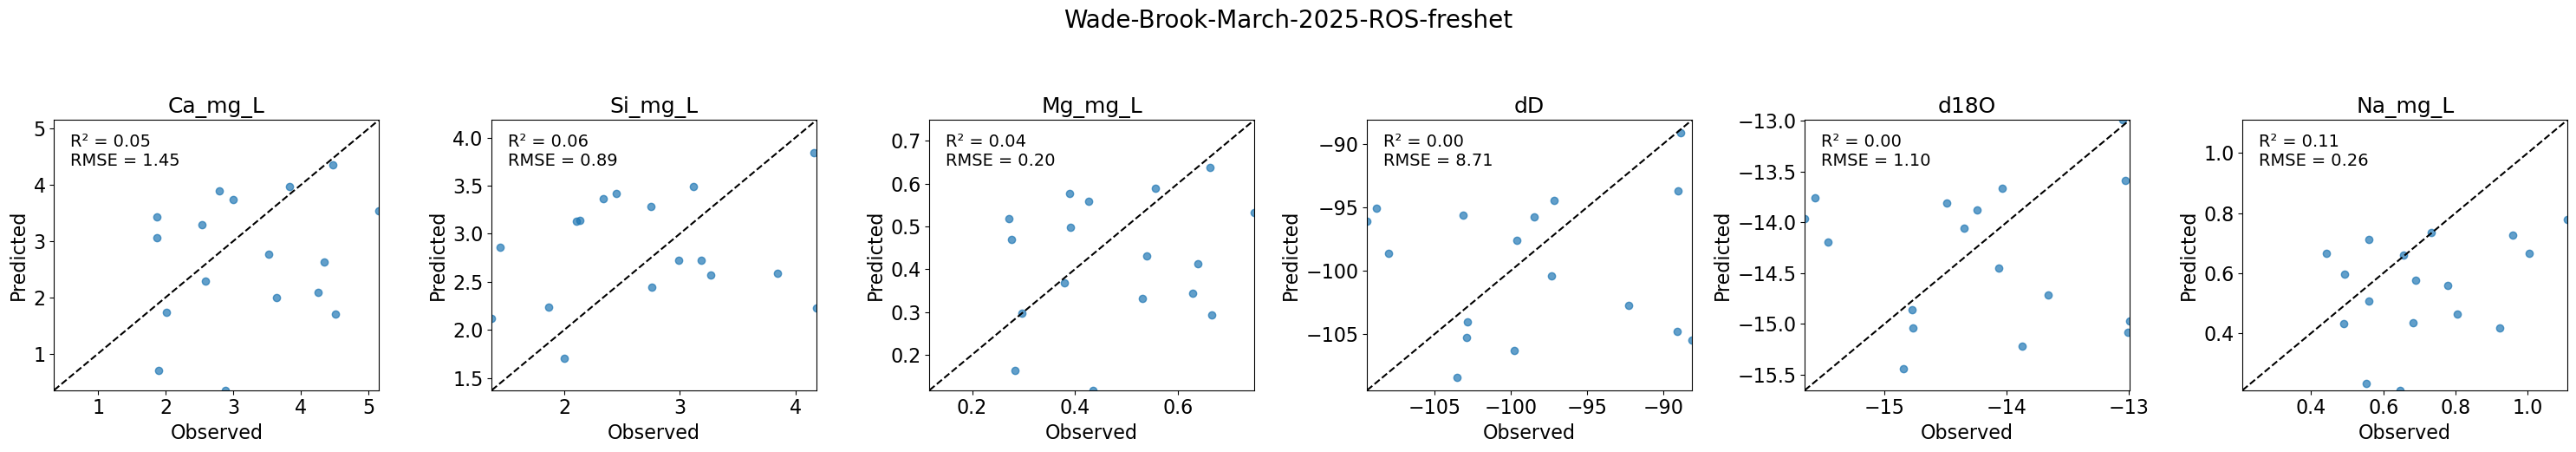

✅ Figure saved to output/EMMA-error-plots/Wade-Brook-March-2025-ROS-freshet.png


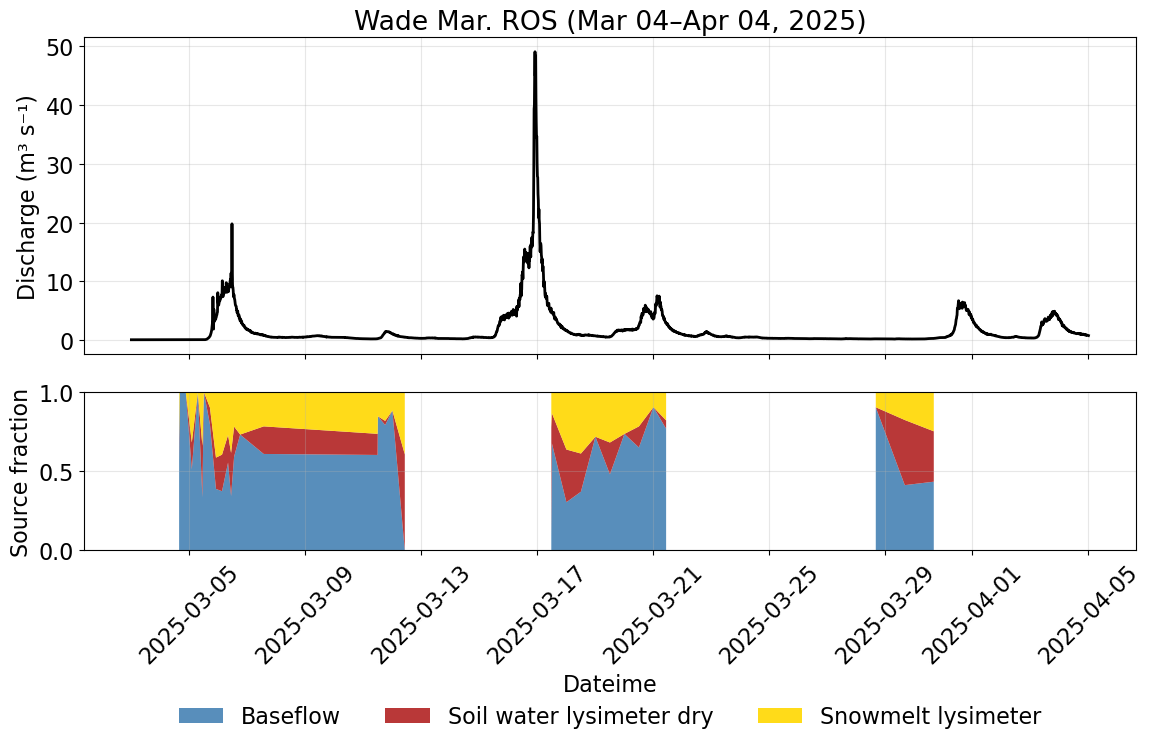

In [62]:
# Load the full RI25 dataset
df = pd.read_csv("data/newrnet-chemistry/RI25/RI25-IC-ICP-isotope-joined.csv")

####################
# Wade RI25 events #
####################

# Step 1: PCA
# Event B
# Wade 03/24 ROS event
# Endmembers: 
        #"RI25-1229", # Snowmelt lysimeter
        #"RI25-1115", # Soil water lysimeter dry 
        #"RI25-1183", "RI25-1201", "RI25-1290"],  #Baseflow

wade_marros_tracers, wade_marros_pca = plot_event_pca(
    data=df,
    site="Wade",
    start_date="2025-03-03",
    end_date="2025-04-05",
    endmember_ids=["RI25-1229", # Snowmelt lysimeter
                   "RI25-1115", # Soil water lysimeter dry 
                   "RI25-1183"],  #Baseflow
    title="PCA for Wade Mar. ROS (Mar 24–Mar 28, 2025)"
)

# Step 2: EMMA: Wade December ROS event
# Event A
# Wade 12/29 ROS event
# Endmembers: 
            #"RI25-1128", Snow cores from Dec '24                   
            #"RI25-1123", # Soil water lysimeter dry 12/06/2024
            #"RI25-1126"]#, #Baseflow 12/06/2024

wade_marros_fractions_df, wade_marros_scaler, wade_marros_pca, wade_marros_endmembers_df = run_emma_event(
    data=df,
    site="Wade",
    start_date="2025-03-03",
    end_date="2025-04-05",
    endmember_ids=["RI25-1229", # Snowmelt lysimeter
                   "RI25-1115", # Soil water lysimeter dry 
                   "RI25-1183"],  #Baseflow
)

wade_tracers = ['Ca_mg_L', 'Si_mg_L', 'Mg_mg_L', 'dD', 'd18O', 'Na_mg_L']

# Call the prediction function
wade_marros_predicted = predict_tracers_from_fractions(
    fractions_df=wade_marros_fractions_df,
    endmembers_df=wade_marros_endmembers_df,
    tracer_cols=wade_tracers
)

# Plot observed vs predicted tracer values
plot_observed_vs_predicted("Wade-Brook-March-2025-ROS-freshet", wade_marros_predicted, df, wade_tracers)

plot_emma_fractions_with_hydrograph(
    fractions_df= wade_marros_fractions_df,
    discharge_csv="/home/millieginty/OneDrive/git-repos/LCBP-interannual-EMMAs/Data/StreamSensor_data/Discharge.Discharge_cms@Wade_Brook.20221001.csv",
    start_date="2025-03-03 00:00:00",
    end_date="2025-04-05 00:00:00",
    site="Wade",
    title="Wade Mar. ROS (Mar 04–Apr 04, 2025)"
)